# Task.
Show different approaches in building recommendations systems. Build books recommendation system.


1. 35% of the purchases on Amazon are the result of their recommender system, according to McKinsey.

2. During the Chinese global shopping festival of November 11, 2016, Alibaba achieved growth of up to 20% of their conversion rate using personalized landing pages, according to Alizila.

3. Recommendations are responsible for 70% of the time people spend watching videos on YouTube.

4. 75% of what people are watching on Netflix comes from recommendations, according to McKinsey.

5. Employing a recommender system enables Netflix to save around $1 billion each year

# General theory:
Recommendation systems are software tools that provides suggestions about items for user. This system provides suggestions for user in decision making such as where to plan a tour, what items can be brought, what exciting news are there to read etc. It has the ability to cope with the information overload problem.     

# Approaches:

Main:

1. Content Based Recommendation System (CBR)
CBR system is based on item description and the profile of the user that is build according to their preferences 

2. Collaborative Filtering Recommendation System (item based, user based)

2.1 Item based - In this system, item relationships are identified using user- item matrix and use this to calculate recommendation for users indirectly. It provides users, an item as a recommendation, depending on other items with high correlations. A set of similar items for each item is first found i.e. the set of their neighbours. This system predicts the ratings of the user for a particular item depending on the rating given to the similar item by the same user.

2.2 User based - It finds the users with common interests and considers them as the nearest neighbours.
Additional:

3. Hybrid Recommendation System
In order to increase the efficiency of recommendation systems, hybrid recommendation system is demonstrated that combines the above two recommendation systems. It can be implemented in three ways – (a) by separately making predictions and then combining them , (b) adding functions of content based system to collaborative system and (c) combining the models into one model. 

4. Context Aware Recommendation System
Context is any information that characterizes the situation of an entity such as person, place or object. This system considers five main types of contextual data such as location, time, weather, personalization and social media entertainment

5. Knowledge Based Recommendation System
This system recommends products based on the requirements of the user and their preferences. It requires a functional knowledge about the user for satisfying them by recommending a particular item. So, there is a large use of domain knowledge. Its decision is independent of individual, so there is no need to collect information about a particular user. Constraint based knowledge recommendation system is capable of recommending complex items 

In [1]:
#import necesaary packages
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, PorterStemmer

from keras.layers import Input, Embedding, Flatten
from keras.layers import Input, InputLayer, Dense, Embedding, Flatten
from keras.layers.merge import dot, add
from keras.engine import Model
from keras.regularizers import l2
from keras.optimizers import Adam

Using TensorFlow backend.


# Data upload and explore

Dataset description:
https://github.com/zygmuntz/goodbooks-10k

In [ ]:
#for local runs
def get_app_credentials_path(file_name: str) ->str:
    abs_path = os.path.dirname(os.path.realpath('__file__'))
    return os.path.join(abs_path, file_name)

books = pd.read_csv(get_app_credentials_path('data/books.csv'))
books = books.drop(['image_url','small_image_url','isbn','isbn13'],axis=1)
ratings = pd.read_csv(get_app_credentials_path('data/ratings.csv'))
book_tags = pd.read_csv(get_app_credentials_path('data/book_tags.csv'))
to_read = pd.read_csv(get_app_credentials_path('data/to_read.csv'))
tags = pd.read_csv(get_app_credentials_path('data/tags.csv'))

In [2]:
books = pd.read_csv('../input/books.csv', encoding = "ISO-8859-1")
books = books.drop(['image_url','small_image_url','isbn','isbn13'],axis=1)
ratings = pd.read_csv('../input/ratings.csv', encoding = "ISO-8859-1")
book_tags = pd.read_csv('../input/book_tags.csv', encoding = "ISO-8859-1")
tags = pd.read_csv('../input/tags.csv')
to_read = pd.read_csv('../input/to_read.csv')
tags = tags.set_index('tag_id')
user_extended = books.merge(ratings, on = 'book_id', how = 'inner')

EDA (Exploratory Data Analysis)

In [3]:
def statistic_exploration(df):
    
    print('The data has {} Rows and {} columns'.format(df.shape[0], df.shape[1]))
    
    col_list = ['Null','Unique_Count','Count_all', 'Data_type', 'Missing_%', 
                'Max/Min','Mean', 'Median',
                'Variance', 'Kurtosis', 'Std', 'Skewness']
    
    df_stat = pd.DataFrame(index=df.columns, columns=col_list)
    df_stat['Null'] = list([len(df[col][df[col].isnull()]) for i, col in enumerate(df.columns)])
    df_stat['Unique_Count'] = list([len(df[col].unique()) for i, col in enumerate(df.columns)])
    df_stat['Count_all'] = list([df[col].count() for i, col in enumerate(df.columns)])
    df_stat['Data_type'] = list([df[col].dtype for i, col in enumerate(df.columns)])
    df_stat['Missing_%'] = list([abs(100 - ((len(df[col].isnull())*100)/df[col].count()))
                                 for i, col in enumerate(df.columns)])
    
    for i,col in enumerate(df.columns):
        if 'float' in str(df[col].dtype) or 'int' in str(df[col].dtype):
            
            df_stat.at[col,'Max/Min'] = str(round(df[col].max(),2)) + '/' + str(round(df[col].min(),2))
            df_stat.at[col,'Mean'] = df[col].mean()
            df_stat.at[col,'Median'] = df[col].median()
            df_stat.at[col,'Variance'] = df[col].var()
            df_stat.at[col,'Kurtosis'] = df[col].kurt()
            df_stat.at[col,'Std'] = df[col].std()
            df_stat.at[col,'Skewness'] = df[col].skew()
            
    print(df.dtypes.value_counts())
    print('Data sample:')
    print(df.sample(1).T)
    return (df_stat.fillna('---'))

In [4]:
stat_books = statistic_exploration(books)
stat_books

The data has 10000 Rows and 19 columns
int64      13
object      4
float64     2
dtype: int64
Data sample:
                                                               5645
id                                                             5646
book_id                                                       73095
best_book_id                                                  73095
work_id                                                        2548
books_count                                                      40
authors                                    Susan Elizabeth Phillips
original_publication_year                                      1998
original_title                                 Dream a Little Dream
title                      Dream a Little Dream (Chicago Stars, #4)
language_code                                                 en-US
average_rating                                                 4.18
ratings_count                                                 24117
work_rati

,Null,Unique_Count,Count_all,Data_type,Missing_%,Max/Min,Mean,Median,Variance,Kurtosis,Std,Skewness
id,0,10000,10000,int64,0.000000,10000/1,5000.5,5000.5,8.33417e+06,-1.2,2886.9,0
book_id,0,10000,10000,int64,0.000000,33288638/1,5.2647e+06,394966,5.73876e+13,0.688732,7.57546e+06,1.34525
best_book_id,0,10000,10000,int64,0.000000,35534230/1,5.47121e+06,425124,6.12671e+13,0.746497,7.82733e+06,1.35031
work_id,0,10000,10000,int64,0.000000,56399597/87,8.64618e+06,2.71952e+06,1.38087e+14,2.49411,1.17511e+07,1.76305
books_count,0,597,10000,int64,0.000000,3455/1,75.7127,40,29060.3,95.303,170.471,8.41009
authors,0,4664,10000,object,0.000000,---,---,---,---,---,---,---
original_publication_year,21,294,9979,float64,0.210442,2017.0/-1750.0,1981.99,2004,23279.6,240.597,152.577,-14.7552
original_title,585,9275,9415,object,6.213489,---,---,---,---,---,---,---
title,0,9964,10000,object,0.000000,---,---,---,---,---,---,---
language_code,1084,26,8916,object,12.157918,---,---,---,---,---,---,---


In [5]:
stat_ratings = statistic_exploration(ratings)
stat_ratings

The data has 981756 Rows and 3 columns
int64    3
dtype: int64
Data sample:
         612779
book_id    6154
user_id    3624
rating        4


,Null,Unique_Count,Count_all,Data_type,Missing_%,Max/Min,Mean,Median,Variance,Kurtosis,Std,Skewness
book_id,0,10000,981756,int64,0.0,10000/1,4943.275636,4921.0,8.255321e+06,-1.190619,2873.207415,0.020893
user_id,0,53424,981756,int64,0.0,53424/1,25616.759933,25077.0,2.319023e+08,-1.171870,15228.338826,0.103903
rating,0,5,981756,int64,0.0,5/1,3.856534,4.0,9.681396e-01,-0.077415,0.983941,-0.618098


In [6]:
stat_to_read = statistic_exploration(to_read)
stat_to_read

The data has 912705 Rows and 2 columns
int64    2
dtype: int64
Data sample:
         841976
user_id   49212
book_id    1332


,Null,Unique_Count,Count_all,Data_type,Missing_%,Max/Min,Mean,Median,Variance,Kurtosis,Std,Skewness
user_id,0,48871,912705,int64,0.0,53424/1,27668.980115,27799.0,2.183035e+08,-1.118823,14775.096388,-0.043635
book_id,0,9986,912705,int64,0.0,10000/1,2454.739538,1381.0,6.897766e+06,0.314759,2626.359921,1.169598


In [7]:
stat_tags = statistic_exploration(tags)
stat_tags

The data has 34252 Rows and 1 columns
object    1
dtype: int64
Data sample:
tag_id          29126
tag_name  sweet-salty


,Null,Unique_Count,Count_all,Data_type,Missing_%,Max/Min,Mean,Median,Variance,Kurtosis,Std,Skewness
tag_name,0,34252,34252,object,0.0,---,---,---,---,---,---,---


In [8]:
stat_tags = statistic_exploration(user_extended)
stat_tags

The data has 79701 Rows and 21 columns
int64      15
object      4
float64     2
dtype: int64
Data sample:
                                                               14950
id                                                               516
book_id                                                         3985
best_book_id                                                    3985
work_id                                                      2693329
books_count                                                       80
authors                                               Michael Chabon
original_publication_year                                       2000
original_title             The Amazing Adventures of Kavalier & Clay
title                      The Amazing Adventures of Kavalier & Clay
language_code                                                    eng
average_rating                                                  4.17
ratings_count                                                 147

,Null,Unique_Count,Count_all,Data_type,Missing_%,Max/Min,Mean,Median,Variance,Kurtosis,Std,Skewness
id,0,812,79701,int64,0.000000,10000/2,3336.51,2564,8.40244e+06,-0.707883,2898.7,0.707961
book_id,0,812,79701,int64,0.000000,9998/1,4909.96,5068,7.91876e+06,-0.983195,2814.03,-0.0387115
best_book_id,0,812,79701,int64,0.000000,33586715/1,288030,5128,6.93101e+12,112.445,2.63268e+06,10.3859
work_id,0,812,79701,int64,0.000000,41335427/87,2.08477e+06,1.38504e+06,1.16388e+13,64.2628,3.41157e+06,6.99956
books_count,0,290,79701,int64,0.000000,3455/2,179.014,75,129432,22.6607,359.766,4.40467
authors,0,480,79701,object,0.000000,---,---,---,---,---,---,---
original_publication_year,100,149,79601,float64,0.125627,2009.0/-762.0,1939.08,1994,86289.9,63.1407,293.751,-7.90304
original_title,1781,795,77920,object,2.285678,---,---,---,---,---,---,---
title,0,812,79701,object,0.000000,---,---,---,---,---,---,---
language_code,11139,7,68562,object,16.246609,---,---,---,---,---,---,---


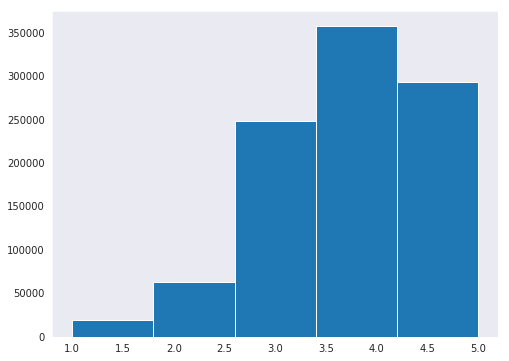

In [9]:
sns.set_style('dark')  
%matplotlib inline

plt.figure(figsize=(8,6)) 
ratings.rating.hist(bins = 5, grid=False)

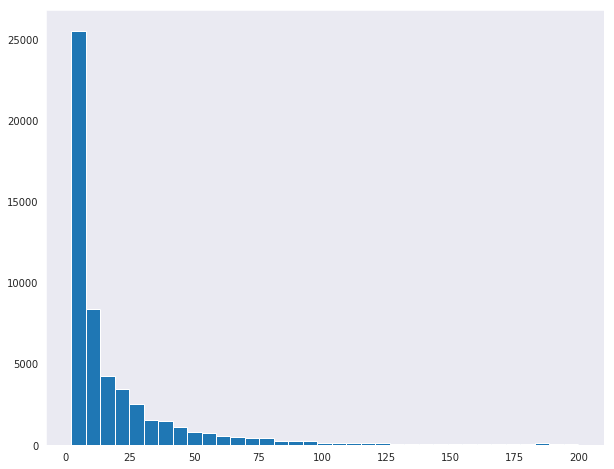

In [10]:
df_user_rating_freq = ratings.groupby(['user_id'])['user_id'].agg(['count']).reset_index()
df_user_rating_freq.rename(columns = {'count' : 'count_review'}, inplace = True)
plt.figure(figsize=(10,8)) 
df_user_rating_freq.count_review.hist(bins = 35, grid=False)

It is good idea to drop users with less than 5 reviews. 

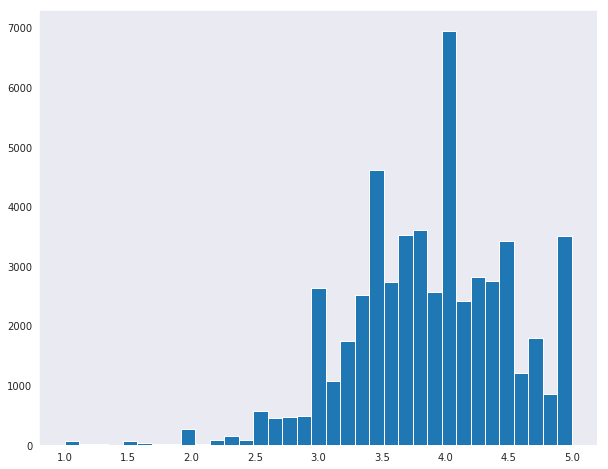

In [11]:
df_user_rating_mean = ratings.groupby(['user_id'])['rating'].agg(['mean']).reset_index()
df_user_rating_mean.rename(columns = {'mean' : 'mean_rating'}, inplace = True)
plt.figure(figsize=(10,8)) 
df_user_rating_mean.mean_rating.hist(bins = 35, grid=False)

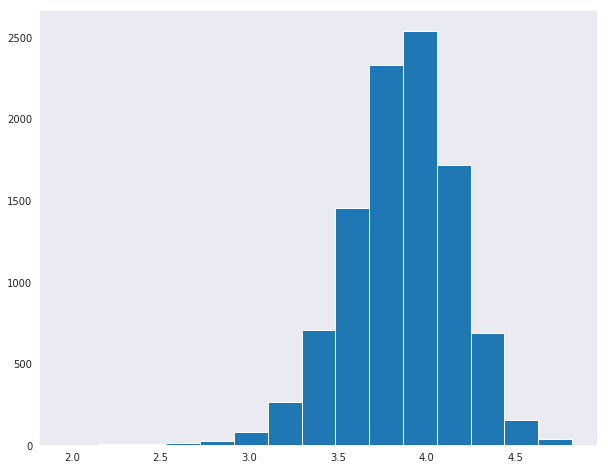

In [12]:
df_book_review_count = ratings.groupby(['book_id'])['rating'].agg(['mean']).reset_index()
df_book_review_count.rename(columns = {'mean' : 'mean_book_review'}, inplace = True)
plt.figure(figsize=(10,8)) 
df_book_review_count.mean_book_review.hist(bins = 15, grid=False)

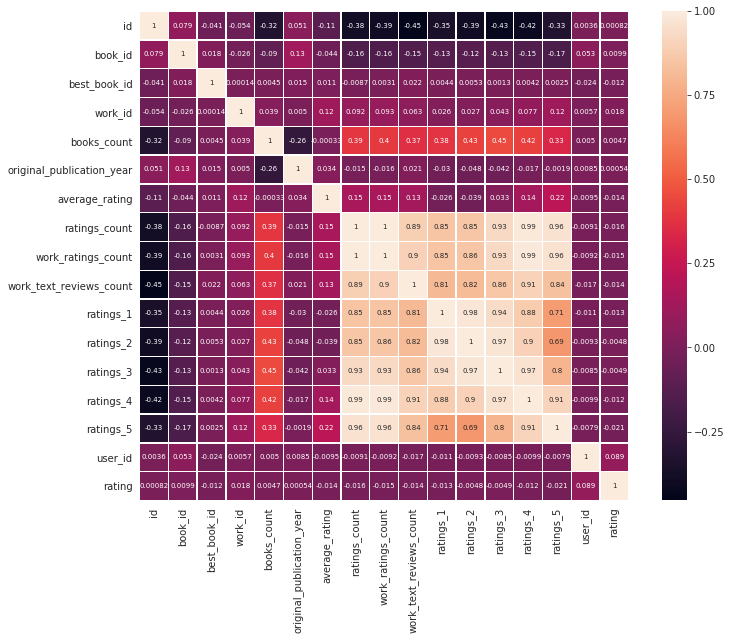

In [13]:
corr = user_extended.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr,
            annot=True,
            annot_kws={"size": 7},
            square=True,
            linewidths=.3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50dad423c8>,
      dtype=object)

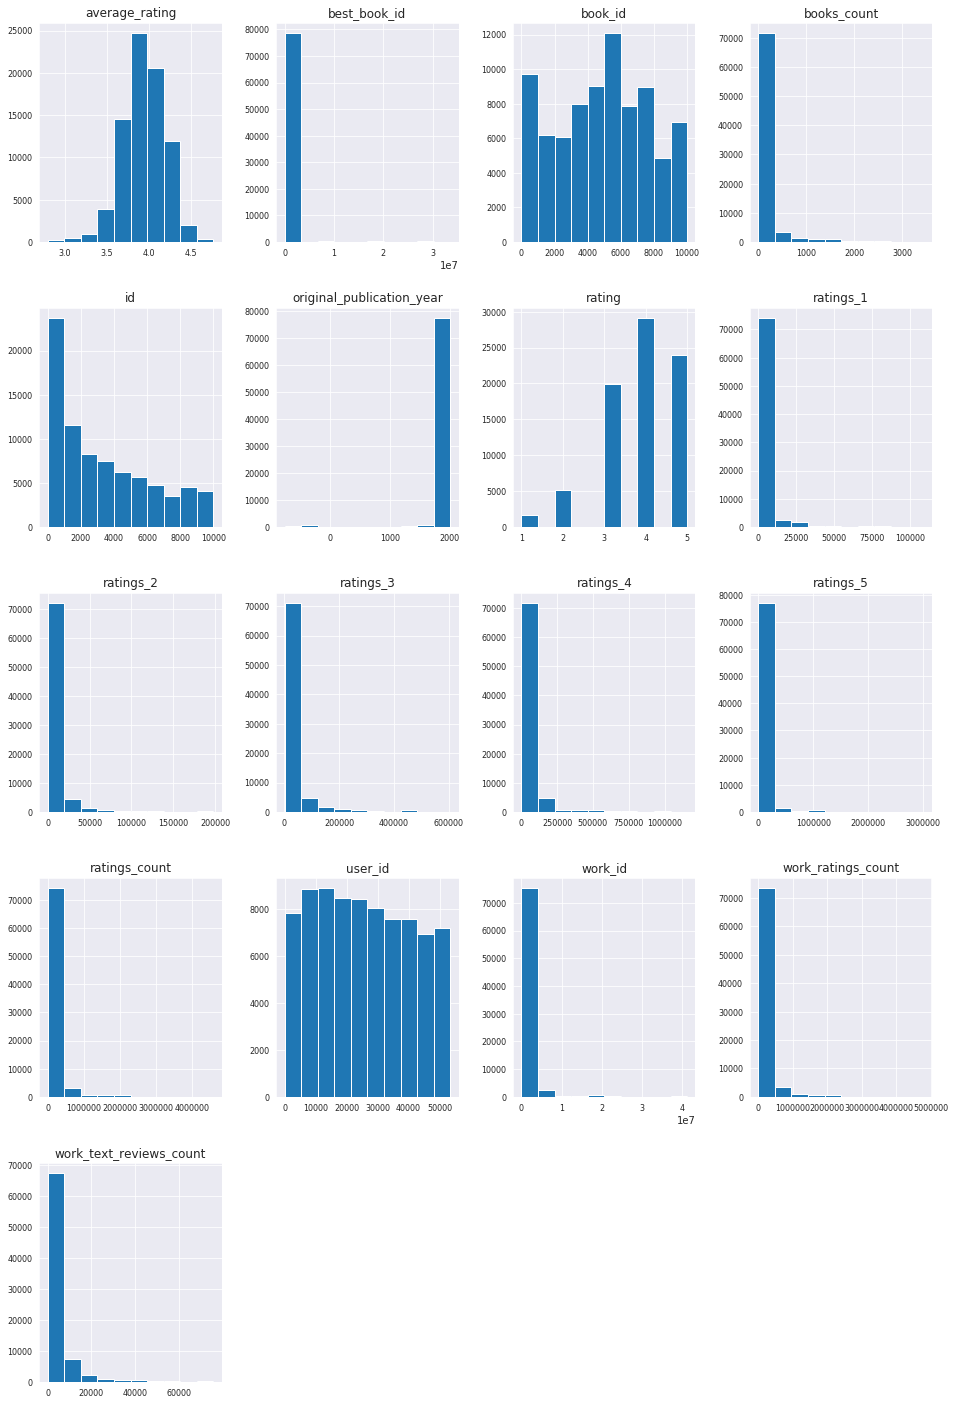

In [14]:
user_extended.hist(figsize=(16, 25), bins=10, xlabelsize=8, ylabelsize=8)

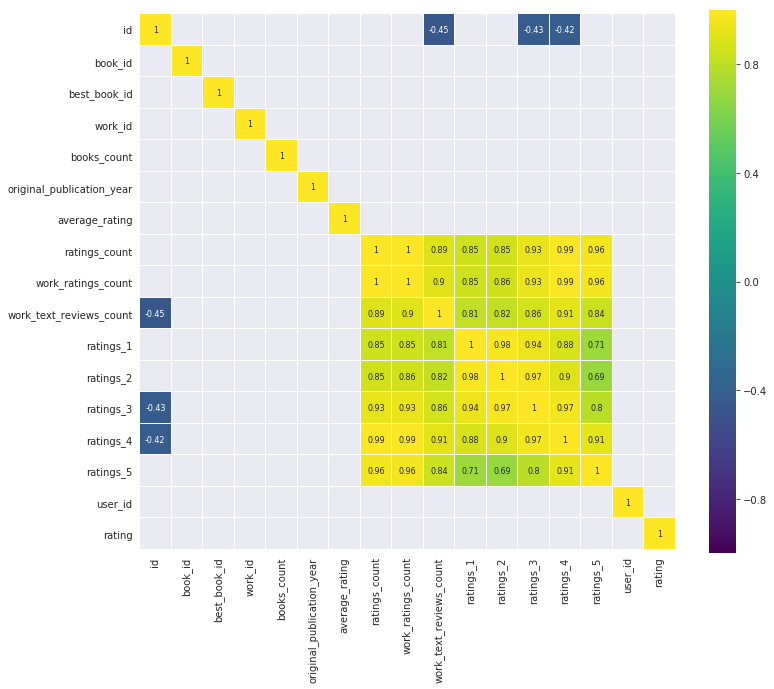

In [15]:
corr = user_extended.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

In [16]:
from statsmodels.formula.api import ols
model = ols("rating  ~ language_code + authors + book_id + original_publication_year", user_extended).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     9.748
Date:                Thu, 23 May 2019   Prob (F-statistic):               0.00
Time:                        06:10:06   Log-Likelihood:                -94038.
No. Observations:               68462   AIC:                         1.890e+05
Df Residuals:                   68022   BIC:                         1.930e+05
Df Model:                         439                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                                                                                  

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

An R-squared of 100% means that all movements of a security (or other dependent variable) are completely explained by movements in the index (or the independent variable(s) you are interested in).

An F-test is a statistical test used basically to find out if 2 variances are equal. 

The F-test plays an important role in the analysis of variance (ANOVA) and in regression analysis to find out if the model fits the data well.

Compare the p-value for the F-test to your significance level. If the p-value is less than the significance level, your sample data provide sufficient evidence to conclude that your regression model fits the data better than the model with no independent variables.

Skew - if the bulk of the data is at the left and the right tail is longer, we say that the distribution is skewed right or positively skewed; if the peak is toward the right and the left tail is longer, we say that the distribution is skewed left or negatively skewed. 

Kurtosis - traditionally, kurtosis has been explained in terms of the central peak. You’ll see statements like this one: Higher values indicate a higher, sharper peak; lower values indicate a lower, less distinct peak. 

The reference standard is a normal distribution, which has a kurtosis of 3. 
A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic.
A distribution with kurtosis <3 (excess kurtosis <0) is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.
A distribution with kurtosis >3 (excess kurtosis >0) is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.

Durbin - watson 

The Durbin Watson Test is a measure of autocorrelation (also called serial correlation) in residuals from regression analysis. Autocorrelation is the similarity of a time series over successive time intervals. It can lead to underestimates of the standard error and can cause you to think predictors are significant when they are not. 

Durbin Watson test reports a test statistic, with a value from 0 to 4, where:

2 is no autocorrelation.
0 to <2 is positive autocorrelation (common in time series data).
from 2 to 4 is negative autocorrelation (less common in time series data).

Homework - add additional exploration with insights 

1. Distribution of Genres
2. Different languages
3. What influences a book’s rating?
4. Is there a relationship between the number of ratings and the average rating?
5. Multiple editions of each book
6. Do frequent raters rate differently?
7. Series of books
8. Is the sequel better than the original?
9. How long should a title be?
10. Does having a subtitle improve the book’s rating?
11. Does the number of authors matter?
12. Which users we can filter?
13. What additional features can be created?

# Popularity model

In [17]:
book_ratings = ratings.groupby('book_id').size().reset_index(name='users')
book_popularity = ratings.groupby('book_id')['rating'].sum().sort_values(ascending=False).reset_index()
book_popularity = pd.merge(book_popularity, book_ratings, how='inner', on=['book_id'])
book_popularity = pd.merge(book_popularity, books[['book_id', 'title', 'authors']], how='inner', on=['book_id'])
book_popularity = book_popularity.sort_values(by=['rating'], ascending=False)
book_popularity.head()

,book_id,rating,users,title,authors
0,9566,473,99,Still Life with Woodpecker,Tom Robbins
1,4708,466,100,The Beautiful and Damned,F. Scott Fitzgerald
2,3885,455,100,The Taste of Home Cookbook,"Janet Briggs, Beth Wittlinger"
3,2767,454,100,A People's History of the United States,Howard Zinn
4,2865,453,100,Girl with a Pearl Earring,Tracy Chevalier


In [18]:
book_popularity.rating = book_popularity.rating / book_popularity.users
book_popularity = book_popularity.sort_values(by=['rating'], ascending=False)

book_popularity.head(25)

,book_id,rating,users,title,authors
0,9566,4.777778,99,Still Life with Woodpecker,Tom Robbins
1,4708,4.660000,100,The Beautiful and Damned,F. Scott Fitzgerald
7,9569,4.618557,97,Villa Incognito,Tom Robbins
759,9531,4.557143,70,Peter and the Shadow Thieves (Peter and the St...,"Dave Barry, Ridley Pearson, Greg Call"
2,3885,4.550000,100,The Taste of Home Cookbook,"Janet Briggs, Beth Wittlinger"
3,2767,4.540000,100,A People's History of the United States,Howard Zinn
6,5344,4.535354,99,Hard Times,Charles Dickens
4,2865,4.530000,100,Girl with a Pearl Earring,Tracy Chevalier
5,976,4.500000,100,Deception Point,Dan Brown
61,9712,4.500000,94,Love in the Time of Cholera,"Gabriel GarcÃ­a MÃ¡rquez, Edith Grossman"


Top-N accuracy metrics, which evaluate the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

Recall:
given a list [n, n, n, p, n, n, …]
N the top most important results, how often does p is among the returned N values

Normalized Discounted Cumulative Gain:

A recommender returns some items and we’d like to compute how good the list is. Each item has a relevance score, usually a non-negative number. That’s gain.
Now we add up those scores; that’s cumulative gain.
We’d prefer to see the most relevant items at the top of the list, therefore before summing the scores we divide each by a growing number (usually a logarithm of the item position) - that’s discounting
DCGs are not directly comparable between users, so we normalize them.

Get sample users

In [19]:
user_314 = user_extended[user_extended.user_id == 314]
user_314 = pd.DataFrame(user_314, columns = ['title', 'rating',
                                             'original_publication_year','authors'])
user_314

,title,rating,original_publication_year,authors
0,Harry Potter and the Sorcerer's Stone (Harry P...,3,1997.0,"J.K. Rowling, Mary GrandPrÃ©"
900,Harry Potter and the Prisoner of Azkaban (Harr...,4,1999.0,"J.K. Rowling, Mary GrandPrÃ©, Rufus Beck"
1201,Harry Potter and the Goblet of Fire (Harry Pot...,5,2000.0,"J.K. Rowling, Mary GrandPrÃ©"
1400,Harry Potter and the Half-Blood Prince (Harry ...,5,2005.0,"J.K. Rowling, Mary GrandPrÃ©"
5723,Deception Point,3,2001.0,Dan Brown
11746,Perfume: The Story of a Murderer,3,1985.0,"Patrick SÃ¼skind, John E. Woods"
23375,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4,1973.0,J.R.R. Tolkien
25164,Dune Messiah (Dune Chronicles #2),4,1969.0,Frank Herbert
33882,Memories of My Melancholy Whores,4,2004.0,"Gabriel GarcÃ­a MÃ¡rquez, Edith Grossman"
42282,Chapterhouse: Dune (Dune Chronicles #6),3,1985.0,Frank Herbert


In [20]:
user_7 = user_extended[user_extended.user_id == 7]
user_7 = pd.DataFrame(user_7, columns = ['title', 'rating', 'original_publication_year','authors'])
user_7

,title,rating,original_publication_year,authors
8163,Extremely Loud and Incredibly Close,3,2005.0,Jonathan Safran Foer
10352,Naked,3,1997.0,David Sedaris
23674,White Teeth,5,1999.0,Zadie Smith
52464,"The Oresteia (ÎÏÎ­ÏÏÎµÎ¹Î±, #1-3)",5,-458.0,"Aeschylus, Robert Fagles, William Bedell Stanford"


# Content_based reccomendation system

A content based recommender works with data that the user provides, either explicitly (rating) or implicitly (clicking on a link). Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

In [ ]:
tags_join_DF = pd.merge(book_tags, tags, on='tag_id', how='inner')
tags_join_DF.head()

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books['authors'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0,π] radians.

Homework:
What alternatives can be used to cosine simularity? What are their advantages and disadvantages?

In [ ]:
# Build a 1-dimensional array with book titles
titles = books['original_title']
indices = pd.Series(books.index, index=books['original_title'])

# Function that get book recommendations based on the cosine similarity score of book authors
def authors_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

authors_recommendations('Amsterdam').head(20)

In [ ]:
tags = pd.merge(books, tags_join_DF, left_on='book_id', right_on='goodreads_book_id', how='inner')
tf1 = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix1 = tf1.fit_transform(tags['tag_name'].head(10000))
cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)
titles1 = books['original_title']
indices1 = pd.Series(books.index, index=books['original_title'])

# Function that get book recommendations based on the cosine similarity score of books tags
def tags_recommendations(title):
    idx = indices1[title]
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

tags_recommendations('Amsterdam').head(20)

Recommendation of books using the authors and tags attributes for better results. Creating corpus of features and calculating the TF-IDF on the corpus of attributes for gettings better recommendations.

In [ ]:
temp_df = tags.groupby('book_id')['tag_name'].apply(' '.join).reset_index()
temp_df.head()

books_c = pd.merge(books, temp_df, left_on='book_id', right_on='book_id', how='inner')
books_c['corpus'] = (pd.Series(books_c[['authors', 'tag_name']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

tf_corpus = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix_corpus = tf_corpus.fit_transform(books_c['corpus'])
cosine_sim_corpus = linear_kernel(tfidf_matrix_corpus, tfidf_matrix_corpus)

# Build a 1-dimensional array with book titles
titles = books['original_title']
indices = pd.Series(books.index, index=books['original_title'])

# Function that get book recommendations based on the cosine similarity score of books tags
def corpus_recommendations(title):
    idx = indices1[title]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

corpus_recommendations("Amsterdam")

In [ ]:
users_cb = pd.merge(ratings, books, on='book_id', how='inner')

users_cb = users_cb[users_cb.rating == 5]
users_cb.head()

In [ ]:
def get_rec_for_user(user_id):
    
    users_cb_u = users_cb[users_cb.user_id == user_id]
    users_list = users_cb_u.original_title.unique()
    ch = np.random.choice(users_list)
    print('authors_recommendations')
    print(authors_recommendations(ch).sample(1))
    print('tags_recommendations')
    print(tags_recommendations(ch).sample(1))
    print('corpus_recommendations')
    print(corpus_recommendations(ch).sample(1))

In [ ]:
rec_test = get_rec_for_user(314)

In [ ]:
rec_test = get_rec_for_user(7)

Сontent based advanced system

In [ ]:
#get tag name
def get_tag_name(tag_id):
    return {word for word in tags.loc[tag_id].tag_name.split('-') if word}

get_tag_name(20000)

The aim of this approach is to group similar object together and recommend new objects from the same categories that the user already purchased

In [ ]:
book_tags.head()

In [ ]:
# accumulate all the tags of a book in a single datastructure
book_tags_dict = dict()
for book_id, tag_id, _ in book_tags.values:
    tags_of_book = book_tags_dict.setdefault(book_id, set()) 
    tags_of_book |= get_tag_name(tag_id)

In [ ]:
" ".join(book_tags_dict[105])

In [ ]:
#There are two types of ids in this dataset: best_book_id and book_id 
#we will make two dicts to switch from one to the other
goodread2id = {best_book_id: book_id for book_id, best_book_id in books[['book_id', 'best_book_id']].values}
id2goodread = dict(zip(goodread2id.values(), goodread2id.keys()))
#Then we’re going to do convert the tags into a numpy plain array that we aim to process later. 
#The row position of a tag should match the book_id. Because these start from 1, we will add a DUMMY padding element.
np_tags = np.array(sorted([[0, "DUMMY"]] + [[goodread2id[book_id], " ".join(tags)] for id, tags in book_tags_dict.items()]))
np_tags[:5]

In [ ]:
#process the tags but if you look closely there are many words
#that have the same meaning but are slighly different (because of the context in which they are used).
#We’d like to normalize them as much as possible so as to keep the overall vocabulary small.
#This process can be accomplished through stemming and lemmatization. 
stemmer = PorterStemmer()
stemmer.stem('autobiographical')

Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word’s lemma, or dictionary form.

Stamming, is the process of reducing inflected words to their word stem, base or root form—generally a written word form.

In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stm = PorterStemmer()
    def __call__(self, doc):
        return [self.stm.stem(self.wnl.lemmatize(t)) for t in word_tokenize(doc)]

p = Pipeline([
    ('vectorizer', TfidfVectorizer(
        tokenizer=LemmaTokenizer(),
        strip_accents='unicode',
        ngram_range=(1, 1),
        max_features=1000,
        min_df=0.005,
        max_df=0.5,
    )),
    ('normalizer', StandardScaler(with_mean=False))
])

trans = p.fit_transform(np_tags[:,1])
trans.shape

We will build a sklearn pipeline to process the tags.

We will first be using a tf-idf metric customized to tokenize words with the above implemented Lemmer and Stemmer class. Then we will use a StandardScaler transform to make all the values in the resulting matrix [0, 1] bound.

After this point, the trans variable contains a row for each book, each suck row corresponds to a 1000 dimensional array. Each element of that 1000, is a score for the most important 1000 words that the TfidfVectorizer decided to keep (1000 words chosen from all the book tags provided).

This is the vectorized representation of the book, the vector the contains (many 0 values) the most important (cumulated for all users) words with which people tagged the books.

In [ ]:
users = ratings.set_index('user_id').index.unique().values
len(users)

In [ ]:
ratings.loc[ratings.user_id == users[0]][['book_id', 'rating']].head()

In [ ]:
def books_and_ratings(user_id):
        books_and_ratings_df = ratings.loc[ratings.user_id == user_id][['book_id', 'rating']]
        u_books, u_ratings = zip(*books_and_ratings_df.values)
        return np.array(u_books), np.array(u_ratings)
    
u_books, u_ratings = books_and_ratings(users[0])
u_books.shape, trans[u_books].shape

We then multiply the book’s ratings with the features of the book, to boost the features importance for this user, then add everything together into a single user specific feature vector.

In [ ]:
user_vector = (u_ratings * trans[u_books]) / len(u_ratings)
user_vector.shape

If we get all the features of a book, scale each book by the user’s ratings and then do a mean on all the scaled book features as above, we actually obtain a condensed form of that user’s preferences.

So doing the above we just obtained a user_vector, a 1000 dimensional vector that expresses what the user likes, by combining his prior ratings on the books he read with the respected book_vectors.

In [ ]:
def get_user_vector(user_id):
    u_books, u_ratings = books_and_ratings(user_id)
    u_books_features = trans[u_books]
    u_vector = (u_ratings * u_books_features) / len(u_ratings)
    return u_vector
    
def get_user_vectors():
    user_vector = (u_ratings * trans[u_books]) / len(u_ratings)
    x = user_vector.shape
    user_vectors = np.zeros((len(users), x[0]))
    for user_id in users[:x[0]]:
        u_vector = get_user_vector(user_id)
        user_vectors[user_id, :] = u_vector
    return user_vectors

user_vectors = get_user_vectors()

In [ ]:
trans_feature_names = p.named_steps['vectorizer'].get_feature_names()
np.random.permutation(np.array(trans_feature_names))[:100]

In [ ]:
user_id = 314

pd.DataFrame(
    sorted(
        zip(
            trans_feature_names, 
            user_vectors[user_id].flatten().tolist()
        ), 
        key=lambda x: -x[1]
    )[:20],
    columns=['token', 'relevance']
).T

In [ ]:
def get_content_2(user_id):
    user_vectors = get_user_vectors()
    cosine_similarities = cosine_similarity(np.expand_dims(user_vectors[user_id], 0), trans)
    print(cosine_similarities)
    similar_indices = cosine_similarities.argsort().flatten()[-20:]
    print(similar_indices)
    print(books.loc[books.id.isin(similar_indices)][['title', 'authors']].sample(1))

get_content_2(7)

Advantage

1. Give recommendation based on user preferences.
2. No sparsity problem.
3. No cold start problem
4. Automatic updation

Disadvantage

1. It depends on the preexisting knowledge of the user to give recommendation.

# K-means (сollaborative filtering)

K-Means is a clustering algorithm so that means you can tag a document(song, blog article, video, shopping item) which is not know to before hand. So if you have user documents with you, you can run a k-means against all the items in your data set and provide recommendation. This kind of recommendation is very common for “similar to this” type of recommendation.

In [ ]:
Clustering the users based on their ratings

In [ ]:
Homework:
Visualizing similarities between users

In [21]:
df_user_rating = ratings[['user_id', 'rating']]
df_user_rating_freq = df_user_rating.groupby(['user_id', 'rating'])['user_id'].agg(['count'])
df_rating_pivot = df_user_rating_freq.pivot_table(index='user_id', columns='rating', values='count', fill_value=0)
df_rating_pivot.head()

rating,1,2,3,4,5
user_id,,,,,
1,0,0,1,2,0
2,0,0,0,2,1
3,2,0,0,0,0
4,0,1,0,0,2
5,0,0,1,2,2


k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

In [22]:
kmeans = KMeans(n_clusters=25).fit(df_rating_pivot.as_matrix())
df_rating_pivot['cluster'] = kmeans.labels_
df_rating_pivot.sample(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


rating,1,2,3,4,5,cluster
user_id,,,,,,
11049,0,2,5,5,2,15
28946,0,0,1,1,1,22
48797,0,0,0,0,2,22
15412,0,0,2,7,1,18
15863,0,0,1,0,11,0
21958,0,0,3,3,4,0
2164,0,0,1,1,0,22
28523,0,0,1,4,3,18
51070,0,0,0,1,1,22


In [23]:
df_rating_pivot1 = df_rating_pivot.reset_index()
df_rating_users = pd.DataFrame(df_rating_pivot1, columns = ['user_id', 'cluster'])

In [24]:
cluster_df = pd.merge(user_extended, df_rating_users, on='user_id', how='inner')
cluster_df.sample(3).T

,6919,24362,1336
id,4081,132,5180
book_id,231,3431,2368
best_book_id,231,3431,2368
work_id,1005335,2561472,54350
books_count,53,123,25
authors,Tom Wolfe,Mitch Albom,David McCullough
original_publication_year,2004,2003,1981
original_title,NaN,The Five People You Meet in Heaven,Mornings on Horseback
title,I am Charlotte Simmons,The Five People You Meet in Heaven,Mornings on Horseback
language_code,en-US,NaN,en-US


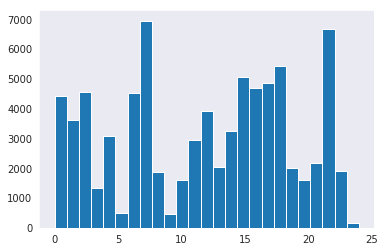

In [26]:
cluster_df.cluster.hist(bins = 25, grid=False)

In [27]:
cluster_list = cluster_df.cluster.unique()

def get_kmeans_rec(user_id):
    cluster_df2 = cluster_df[cluster_df.user_id == user_id]
    user_cluster = cluster_df2.cluster.iloc[0]
    user_books = cluster_df2.original_title.unique()
    cluster_df1 = cluster_df[cluster_df.cluster == user_cluster]
    book_ratings = cluster_df1.groupby('book_id').size().reset_index(name='users')
    book_popularity = cluster_df1.groupby('book_id')['rating'].sum().sort_values(ascending=False).reset_index()
    book_popularity = pd.merge(book_popularity, book_ratings, how='inner', on=['book_id'])
    book_popularity = pd.merge(book_popularity, books[['book_id', 'title', 'authors']], how='inner', on=['book_id'])
    book_popularity = book_popularity.sort_values(by=['rating'], ascending=False)
    book_popularity.rating = book_popularity.rating / book_popularity.users
    book_popularity = book_popularity.sort_values(by=['rating'], ascending=False).head(10)     
    rec_list = book_popularity.title.unique()
    rec_list =  list(set(rec_list) - set(user_books)) 
    print(rec_list[0])
    
get_kmeans_rec(314)

Pompeii


In [28]:
get_kmeans_rec(10)

Consider the Lobster and Other Essays


In [29]:
get_kmeans_rec(7)

The Burden of Proof


Homework:
1. Calculate and vizualize densety of kernela
2. Try aglomerative clustering and compare results?
3. What another clustering methods can be applied?

# Colloborative filtering model-based (Keras)

The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory-based. We say they have large coverage, even when working with large sparse matrices.



In [ ]:
train_df, test_df = train_test_split(ratings,
                                   stratify=ratings['user_id'], 
                                   test_size=0.20,)

len(train_df), len(test_df)

Our goal here is to express each user and each book into some semantic representation derived from the ratings we have.

We will model each id (both user_id, and book_id) as a hidden latent variable sequence (also called embedding). The user_id embeddings would represent that user’s personal tastes. The book_id embeddings would represent the book characteristics.

We then assume that the rating of a user would be the product between his personal tastes (the user’s embeddings) multiplied with the books characteristics (the book embeddings).

we will try to model the formula

rating = user_preferences * book_charatersitcs + user_bias + book_bias

user_bias is a tendency of a user to give higher or lower scores.
book_bias is a tendency of a book to be more known, publicized, talked about so rated higher because of this.
We expect that while training, the ratings will back-propagate enough information into the embeddings so as to jointly decompose both the user_preferences vectors and book_characteristics vectors.

An embedding is a mapping from discrete objects, such as words or ids of books in our case, to a vector of continuous values. This can be used to find similarities between the discrete objects, that wouldn’t be apparent to the model if it didn’t use embedding layers.

The embedding vectors are low-dimensional and get updated whilst training the network.

Neural network embeddings have 3 primary purposes:

1. Finding nearest neighbors in the embedding space. These can be used to make recommendations based on user interests or cluster categories.
2. As input to a machine learning model for a supervised task.
3. For visualization of concepts and relations between categories.



In [ ]:
hidden_factors = 10

# This returns a tensor
user = Input(shape=(1,))
emb_u_w = Embedding(input_length=1, input_dim=len(users), output_dim=hidden_factors)
emb_u_b = Embedding(input_length=1, input_dim=len(users), output_dim=1)

# This returns a tensor
book = Input(shape=(1,))
emb_b_w = Embedding(input_length=1, input_dim=len(books), output_dim=hidden_factors)
emb_b_b = Embedding(input_length=1, input_dim=len(books), output_dim=1)

merged = dot([
    Flatten()(emb_u_w(user)), 
    Flatten()(emb_b_w(book))
], axes=-1)
                   
merged = add([merged, Flatten()(emb_u_b(user))])
merged = add([merged, Flatten()(emb_b_b(book))])

model = Model(inputs=[user, book], outputs=merged)
model.summary()
model.compile(optimizer='adam', loss='mse')
model.optimizer.lr=0.001

Our model has the following structure:
Input: Input for both books and users
Embedding Layers: Embeddings for books and users
Dot: combines embeddings using a dot product
In an embedding model the embeddings are the weights that are learned during training. These embeddings can not only be used for extracting information about the data but can also be extracted and visualized.

In [ ]:
raw_data = train_df[['user_id', 'book_id', 'rating']].values
raw_valid = test_df[['user_id', 'book_id', 'rating']].values

u = raw_data[:,0] - 1
b = raw_data[:,1] - 1
r = raw_data[:,2]

vu = raw_data[:,0] - 1
vb = raw_data[:,1] - 1
vr = raw_data[:,2]


model.fit(x=[u, b], y=r, validation_data=([vu, vb], vr), epochs=1)

In [ ]:
emb_b_w

After the training is done, we can retrieve the embedding values for the books, the users and the biases in order to reproduce the computations ourselves for a single user.

In [ ]:
book_embeddings = emb_b_w.get_weights()[0]
book_embeddings.shape, "10000 books each with 10 hidden features (the embedding)"

Embeddings can be used to visualize concepts such as the relation of different books in our case. To visualize these concepts, we need to further reduce dimensionality using dimensionality reduction techniques like principal component analysis (PSA) or t-distributed stochastic neighbor embedding (TSNE).
Starting with 10000 dimensions (one for each book), we map them to 5 dimensions using embedding and then further map them to 2 dimensions using PCA or TSNE.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_embeddings)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [ ]:
user_embeddings = emb_u_w.get_weights()[0]
user_embeddings.shape, "54k users each with 10 hidden preferences"

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_embeddings)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [ ]:
user_bias = emb_u_b.get_weights()[0]
book_bias = emb_b_b.get_weights()[0]
user_bias.shape, book_bias.shape, "every user and book has a specific bias"

In [ ]:
def get_keras_recomendation(user_id):
    books_ranked_for_user = (np.dot(book_embeddings, user_embeddings[user_id])
                             + user_bias[user_id] + book_bias.flatten())

    books_ranked_for_user.shape
    best_book_ids = np.argsort(books_ranked_for_user)[-150:]
    print(books.loc[books.book_id.isin(best_book_ids)][['title', 'authors']].sample(1))
    
get_keras_recomendation(314)

In [ ]:
get_keras_recomendation(7)

Homework:

1. Train for more epochs
2. Scale the ratings column

Issues with collaborative filtering systems

There are two main challenges that come up with these systems:

Cold start: we should have enough information (user-item interactions) for the system to work. If we setup a new e-commerce site, we cannot give recommendations until users have interacted with a significant number of items.

Adding new users/items to the system: whether it is a new user or item, we have no prior information about them since they don’t have existing interactions.

# Conclusion

In [ ]:
def compare_engines(user_id):

    print('Content based approach:')
    get_rec_for_user(user_id)
    print('Content based extended approach:')
    get_content_2(user_id)
    print('Colloborative: K-means:')
    get_kmeans_rec(user_id)
    print('Colloborative: Deep Learning')  
    get_keras_recomendation(user_id)

In [ ]:
%time compare_engines(314)

In [ ]:
%time compare_engines(7)

1. Collaborative Similarity Embedding for Recommender Systems
https://arxiv.org/pdf/1902.06188.pdf
2. In-Depth: Kernel Density Estimation
https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
3. PCA
https://en.wikipedia.org/wiki/Principal_component_analysis
4. Keras
https://keras.io
5. Nice longread
https://beta.vu.nl/nl/Images/werkstuk-fernandez_tcm235-874624.pdf
6. Youtube recommender
https://www.researchgate.net/profile/Sujoy_Gupta2/publication/221140967_The_YouTube_video_recommendation_system/links/53e834410cf21cc29fdc35d2/The-YouTube-video-recommendation-system.pdf
7. Tensorflow vizualization magic
http://projector.tensorflow.org

Homework:

Use new dataset to run methods in Notebook.